<a href="https://colab.research.google.com/github/tylergusmyers/API_Fin_Planning/blob/main/ETH_svm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Imports
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.preprocessing import StandardScaler
from pandas.tseries.offsets import DateOffset
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,OneHotEncoder
from sklearn.linear_model import LogisticRegression


In [ ]:
from google.colab import files
uploaded = files.upload()

Saving ETH.csv to ETH (3).csv


In [ ]:
eth_df = pd.read_csv(
    Path('ETH.csv'), 
    index_col='Date', 
    infer_datetime_format=True, 
    parse_dates=True
)

eth_df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-11-09,308.644989,329.451996,307.056000,320.884003,320.884003,893249984
2017-11-10,320.670990,324.717987,294.541992,299.252991,299.252991,885985984
2017-11-11,298.585999,319.453003,298.191986,314.681000,314.681000,842300992
2017-11-12,314.690002,319.153015,298.513000,307.907990,307.907990,1613479936
2017-11-13,307.024994,328.415009,307.024994,316.716003,316.716003,1041889984


In [ ]:
close_df = eth_df.loc[:, ["Close"]]
close_df.head()

,Close
Date,
2017-11-09,320.884003
2017-11-10,299.252991
2017-11-11,314.681000
2017-11-12,307.907990
2017-11-13,316.716003


In [ ]:
# Generate the returns using pct_change
close_df["Actual Returns"] = close_df["Close"].pct_change()
close_df = close_df.dropna()

display(close_df.head())

,Close,Actual Returns
Date,,
2017-11-10,299.252991,-0.067411
2017-11-11,314.681000,0.051555
2017-11-12,307.907990,-0.021523
2017-11-13,316.716003,0.028606
2017-11-14,337.631012,0.066037


In [ ]:
short_window = 4
long_window = 100

# Create the fast and slow window columns
close_df['SMA_Fast'] = close_df['Close'].rolling(window=short_window).mean()
close_df['SMA_Slow'] = close_df['Close'].rolling(window=long_window).mean()

close_df = close_df.dropna()

display(close_df.head())

,Close,Actual Returns,SMA_Fast,SMA_Slow,Signal,Strategy Returns
Date,,,,,,
2020-09-21,341.786072,-0.078875,370.686951,392.142759,-1.0,0.078875
2020-09-22,344.503174,0.007950,360.721611,391.306919,1.0,-0.007950
2020-09-23,321.116302,-0.067886,344.614593,389.931735,-1.0,-0.067886
2020-09-24,349.355591,0.087941,339.190285,388.887036,1.0,-0.087941
2020-09-25,352.183258,0.008094,341.789581,388.031462,1.0,0.008094


In [ ]:
# Create the 'Signal' column for positive or negative returns
close_df['Signal'] = 0.0
close_df.loc[(close_df['Actual Returns'] >= 0), 'Signal'] = 1
close_df.loc[(close_df['Actual Returns'] < 0), 'Signal'] = -1

display(close_df.head())
display(close_df.tail())

,Close,Actual Returns,SMA_Fast,SMA_Slow,Signal,Strategy Returns
Date,,,,,,
2020-08-03,386.295166,0.042149,371.930313,194.211295,1.0,-0.042149
2020-08-04,389.875488,0.009268,383.010521,194.866569,1.0,0.009268
2020-08-05,401.590576,0.030048,387.108238,195.566338,1.0,0.030048
2020-08-06,394.961945,-0.016506,393.180794,196.274313,-1.0,-0.016506
2020-08-07,379.512848,-0.039115,391.485214,196.936600,-1.0,0.039115


,Close,Actual Returns,SMA_Fast,SMA_Slow,Signal,Strategy Returns
Date,,,,,,
2022-01-08,3091.972656,-0.031704,3313.494568,3112.233202,-1.0,0.031704
2022-01-09,3157.751465,0.021274,3215.335693,3116.786699,1.0,-0.021274
2022-01-10,3083.097900,-0.023641,3131.508118,3121.040453,-1.0,-0.023641
2022-01-11,3238.111572,0.050279,3142.733398,3125.755994,1.0,-0.050279
2022-01-12,3363.647217,0.038768,3210.652039,3131.025301,1.0,0.038768


In [ ]:
close_df['Signal'].value_counts()
close_df['Strategy Returns'] = close_df['Actual Returns'] * close_df['Signal'].shift()

display(close_df.head())
close_df.dtypes

,Close,Actual Returns,SMA_Fast,SMA_Slow,Signal,Strategy Returns
Date,,,,,,
2020-08-03,386.295166,0.042149,371.930313,194.211295,1.0,NaN
2020-08-04,389.875488,0.009268,383.010521,194.866569,1.0,0.009268
2020-08-05,401.590576,0.030048,387.108238,195.566338,1.0,0.030048
2020-08-06,394.961945,-0.016506,393.180794,196.274313,-1.0,-0.016506
2020-08-07,379.512848,-0.039115,391.485214,196.936600,-1.0,0.039115


Close               float64
Actual Returns      float64
SMA_Fast            float64
SMA_Slow            float64
Signal              float64
Strategy Returns    float64
dtype: object

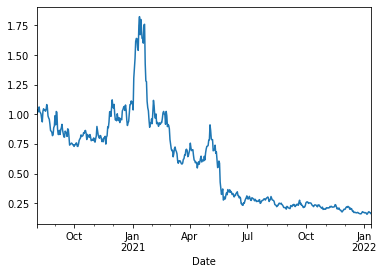

In [ ]:
(1 + close_df['Strategy Returns']).cumprod().plot()

In [ ]:
# Assign sma_fast and sma_slow columns X
X = close_df[['SMA_Fast', 'SMA_Slow']].shift().dropna()
X.head()

# Create the target set 
y = close_df['Signal']
y.value_counts()

 1.0    294
-1.0    234
Name: Signal, dtype: int64

In [ ]:
# Select start of training period
training_begin = X.index.min()
print(training_begin)

# Select the ending period
training_end = X.index.min() + DateOffset(months=8)
print(training_end)

2020-08-04 00:00:00
2021-04-04 00:00:00


In [ ]:
X_train = X.loc[training_begin:training_end]
y_train = y.loc[training_begin:training_end]

X_train.head()

X_test = X.loc[training_end+DateOffset(hours=1):]
y_test = y.loc[training_end+DateOffset(hours=1):]

X_test.head()

,SMA_Fast,SMA_Slow
Date,,
2021-04-05,2060.511932,763.994116
2021-04-06,2093.164520,770.204035
2021-04-07,2086.952850,776.440482
2021-04-08,2072.616547,782.238397
2021-04-09,2071.479279,788.408665


In [ ]:
# StandardScaler instance and scale the X_train
scaler = StandardScaler()
X_scaler = scaler.fit(X_train)

# Transform the X_train and X_test DataFrames using the X_scaler
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)
X_train_scaled[:3]

array([[-0.86925586, -1.03878181],
       [-0.84965362, -1.03462764],
       [-0.84240426, -1.03019138]])

In [ ]:
# Instantiate SVC instance
svm_model = svm.SVC()

# Fit the model 
svm_model = svm_model.fit(X_train_scaled, y_train)
 
# Make the model predictions
svm_pred = svm_model.predict(X_test_scaled)
svm_pred[:10]


array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [ ]:
# Use a classification report to evaluate the model using the predictions and testing data
svm_testing_report = classification_report(y_test, svm_pred)

# Print the classification report
print(svm_testing_report)


              precision    recall  f1-score   support

        -1.0       0.40      0.01      0.02       195
         1.0       0.55      0.99      0.71       239

    accuracy                           0.55       434
   macro avg       0.48      0.50      0.36       434
weighted avg       0.48      0.55      0.40       434



In [ ]:

predictions_df = pd.DataFrame(index=X_test.index)

predictions_df['Predicted'] = svm_pred

predictions_df['Actual Returns'] = close_df["Actual Returns"]
predictions_df['Strategy Returns'] = svm_pred * predictions_df['Actual Returns']

display(predictions_df.head())
display(predictions_df.tail())

,Predicted,Actual Returns,Strategy Returns
Date,,,
2020-11-05,1.0,0.029655,0.029655
2020-11-06,1.0,0.098177,0.098177
2020-11-07,-1.0,-0.041798,0.041798
2020-11-08,-1.0,0.040948,-0.040948
2020-11-09,-1.0,-0.020707,0.020707


,Predicted,Actual Returns,Strategy Returns
Date,,,
2022-01-08,1.0,-0.031704,-0.031704
2022-01-09,1.0,0.021274,0.021274
2022-01-10,1.0,-0.023641,-0.023641
2022-01-11,1.0,0.050279,0.050279
2022-01-12,1.0,0.038768,0.038768


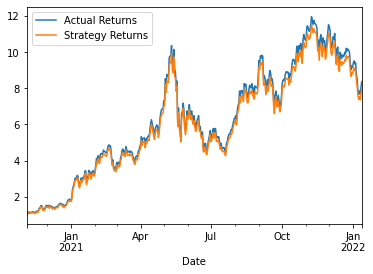

In [ ]:
(1 + predictions_df[["Actual Returns", "Strategy Returns"]]).cumprod().plot()